# Customer Behavior Predictive Analysis
## IIMK's Professional Certificate in Data Science and Artificial Intelligence for Managers
**Student Name**: Lalit Nayyar  
**Email ID**: lalitnayyar@gmail.com  
**Assignment**: Data-Driven Decision Making Analysis

## Overview
This notebook implements predictive analytics to forecast customer behavior and business metrics using machine learning techniques.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set plot style
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Data Loading and Preprocessing
First, we'll load the data and prepare it for predictive analysis.

In [3]:
# Load and clean the data
try:
    # Load data
    print("Loading data...")
    df = pd.read_excel('Online Retail.xlsx')
    print(f"Original dataset shape: {df.shape}")
    
    # Clean data
    def clean_data(df):
        """Clean and preprocess the dataset"""
        print("Cleaning data...")
        df_clean = df.copy()
        
        # Remove missing values
        df_clean = df_clean.dropna()
        print(f"After removing missing values: {len(df_clean)} records")
        
        # Remove cancelled orders
        df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C')]
        print(f"After removing cancelled orders: {len(df_clean)} records")
        
        # Ensure positive quantities and prices
        df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
        print(f"After ensuring positive values: {len(df_clean)} records")
        
        # Convert date and calculate total amount
        df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
        df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
        
        return df_clean.reset_index(drop=True)
    
    # Clean the data
    df_clean = clean_data(df)
    print("Cleaned data sample:")
    display(df_clean.head())
    
    # Basic statistics
    print("Basic statistics:")
    display(df_clean.describe())
    
except FileNotFoundError:
    print("Error: 'Online Retail.xlsx' file not found!")
    df_clean = None
except Exception as e:
    print(f"Error during data preparation: {e}")
    df_clean = None

Loading data...
Original dataset shape: (541909, 8)
Cleaning data...
After removing missing values: 406829 records
After removing cancelled orders: 397924 records
After ensuring positive values: 397884 records
Cleaned data sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Basic statistics:


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalAmount
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


## 2. Feature Engineering
Create customer features for predictive modeling.

Customer features created successfully!
Feature statistics:


,customer_lifetime,purchase_count,total_spent,avg_order_value,total_items,avg_items_per_order,unique_products,purchase_frequency,avg_basket_size
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,130.448594,91.720609,2054.266460,68.350506,1191.289073,45.065550,61.845320,0.702405,68.350506
std,132.039554,228.785094,8989.230441,1467.918896,5046.081546,1203.438033,86.223641,5.215550,1467.918896
min,0.000000,1.000000,3.750000,2.101286,1.000000,1.000000,1.000000,0.000000,2.101286
25%,0.000000,17.000000,307.415000,12.365367,160.000000,6.000000,16.000000,0.000000,12.365367
50%,92.500000,41.000000,674.485000,17.723119,379.000000,10.000000,35.500000,0.201333,17.723119
75%,251.750000,100.000000,1661.740000,24.858417,992.750000,14.666667,78.000000,0.589074,24.858417
max,373.000000,7847.000000,280206.020000,77183.600000,196915.000000,74215.000000,1816.000000,297.000000,77183.600000


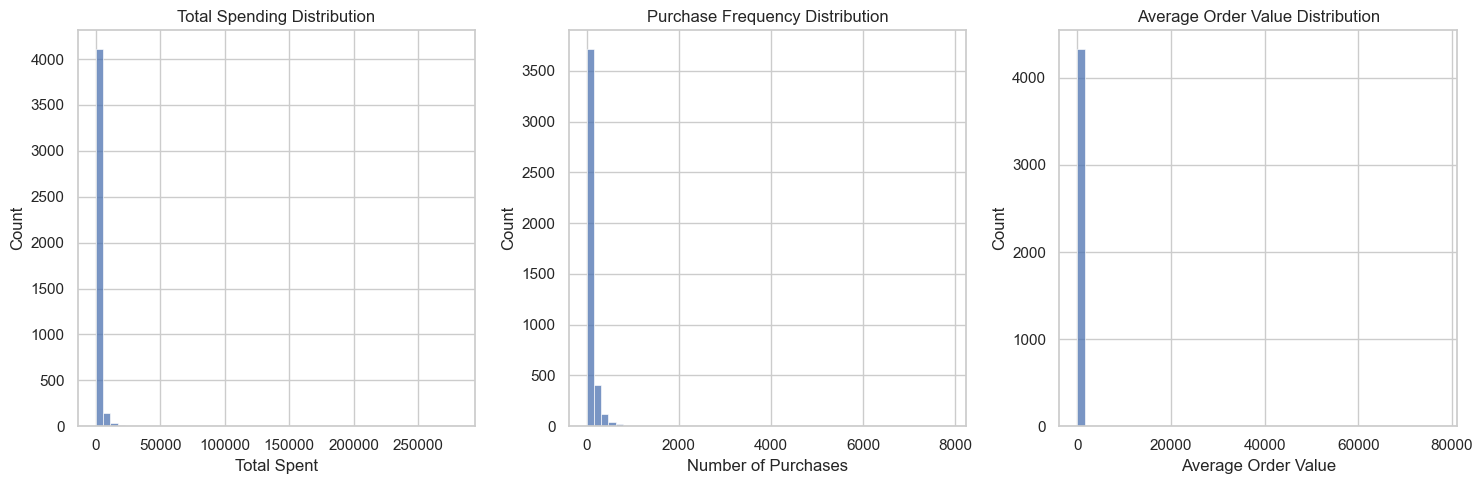

In [4]:
def create_customer_features(df):
    """Create customer-level features for prediction"""
    if df is None:
        return None
        
    try:
        # Group by customer
        customer_features = df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (x.max() - x.min()).days,  # Customer lifetime
            'InvoiceNo': 'count',  # Number of purchases
            'TotalAmount': ['sum', 'mean'],  # Spending metrics
            'Quantity': ['sum', 'mean'],  # Purchase volume
            'Description': 'nunique'  # Product variety
        })
        
        # Flatten column names
        customer_features.columns = [
            'customer_lifetime',
            'purchase_count',
            'total_spent',
            'avg_order_value',
            'total_items',
            'avg_items_per_order',
            'unique_products'
        ]
        
        # Calculate additional features
        customer_features['purchase_frequency'] = customer_features['purchase_count'] / customer_features['customer_lifetime']
        customer_features['avg_basket_size'] = customer_features['total_spent'] / customer_features['purchase_count']
        
        # Handle infinite values
        customer_features = customer_features.replace([np.inf, -np.inf], np.nan)
        customer_features = customer_features.fillna(0)
        
        return customer_features
        
    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None

# Create features
customer_features = create_customer_features(df_clean)
if customer_features is not None:
    print("Customer features created successfully!")
    print("Feature statistics:")
    display(customer_features.describe())
    
    # Visualize feature distributions
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    sns.histplot(data=customer_features['total_spent'], bins=50)
    plt.title('Total Spending Distribution')
    plt.xlabel('Total Spent')
    
    plt.subplot(132)
    sns.histplot(data=customer_features['purchase_count'], bins=50)
    plt.title('Purchase Frequency Distribution')
    plt.xlabel('Number of Purchases')
    
    plt.subplot(133)
    sns.histplot(data=customer_features['avg_order_value'], bins=50)
    plt.title('Average Order Value Distribution')
    plt.xlabel('Average Order Value')
    
    plt.tight_layout()
    plt.show()

## 3. Predictive Modeling
Implement machine learning models to predict customer behavior.

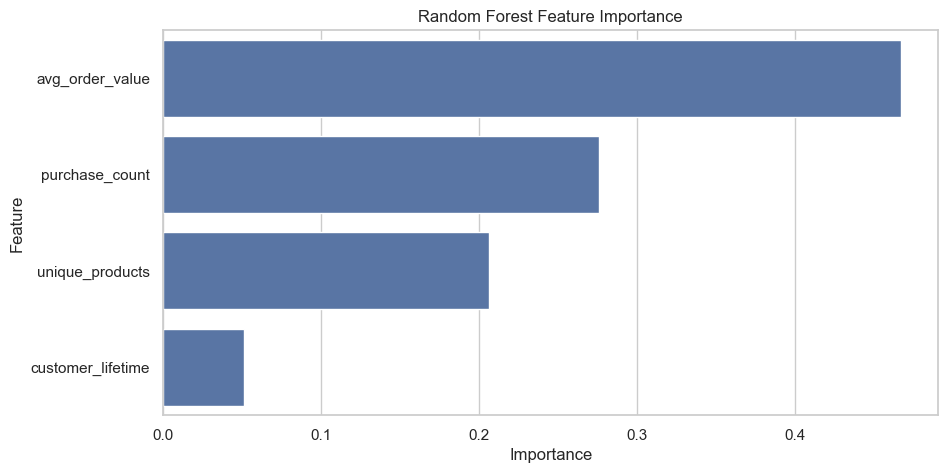

Model Performance Metrics:


,Random Forest,Gradient Boosting
R2 Score,0.759,0.904
MAE,417.260,443.750
RMSE,4972.380,3134.277


In [5]:
def train_prediction_models(features):
    """Train and evaluate prediction models"""
    if features is None:
        return None
        
    try:
        # Prepare features for prediction
        X = features[['purchase_count', 'avg_order_value', 'unique_products', 'customer_lifetime']]
        y = features['total_spent']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train models
        models = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42)
        }
        
        results = {}
        for name, model in models.items():
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            results[name] = {
                'R2 Score': r2_score(y_test, y_pred),
                'MAE': mean_absolute_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
            }
            
            # Feature importance
            if name == 'Random Forest':
                importance = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': model.feature_importances_
                }).sort_values('Importance', ascending=False)
                
                plt.figure(figsize=(10, 5))
                sns.barplot(data=importance, x='Importance', y='Feature')
                plt.title(f'{name} Feature Importance')
                plt.show()
        
        # Display results
        results_df = pd.DataFrame(results).round(3)
        print("Model Performance Metrics:")
        display(results_df)
        
        return models, results_df
        
    except Exception as e:
        print(f"Error in predictive modeling: {e}")
        return None

# Train models
model_results = train_prediction_models(customer_features)

## 4. Customer Segmentation
Segment customers based on their behavior patterns.

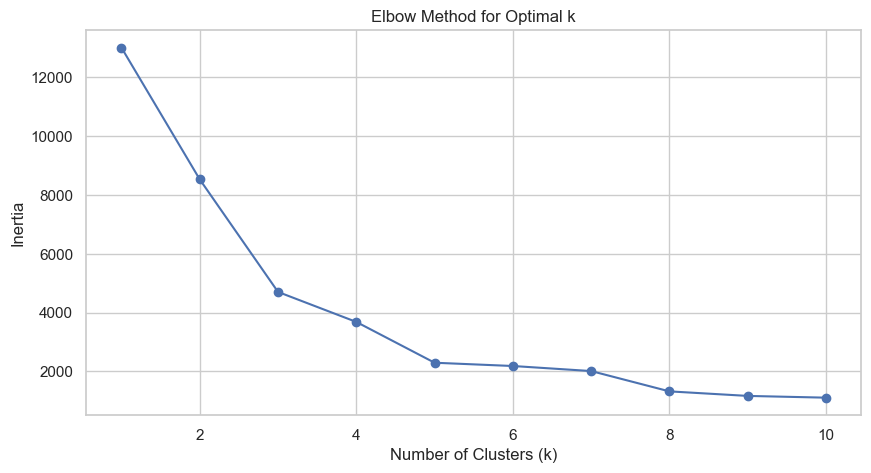

Cluster Analysis:


,avg_total_spent,customer_count,avg_purchase_count,avg_order_value,avg_unique_products
Cluster,,,,,
0,1078.43,4030,58.52,32.99,46.91
1,122828.05,2,2.00,66670.55,2.00
2,10130.01,296,444.21,96.52,237.88
3,132117.73,10,3056.50,164.97,883.00


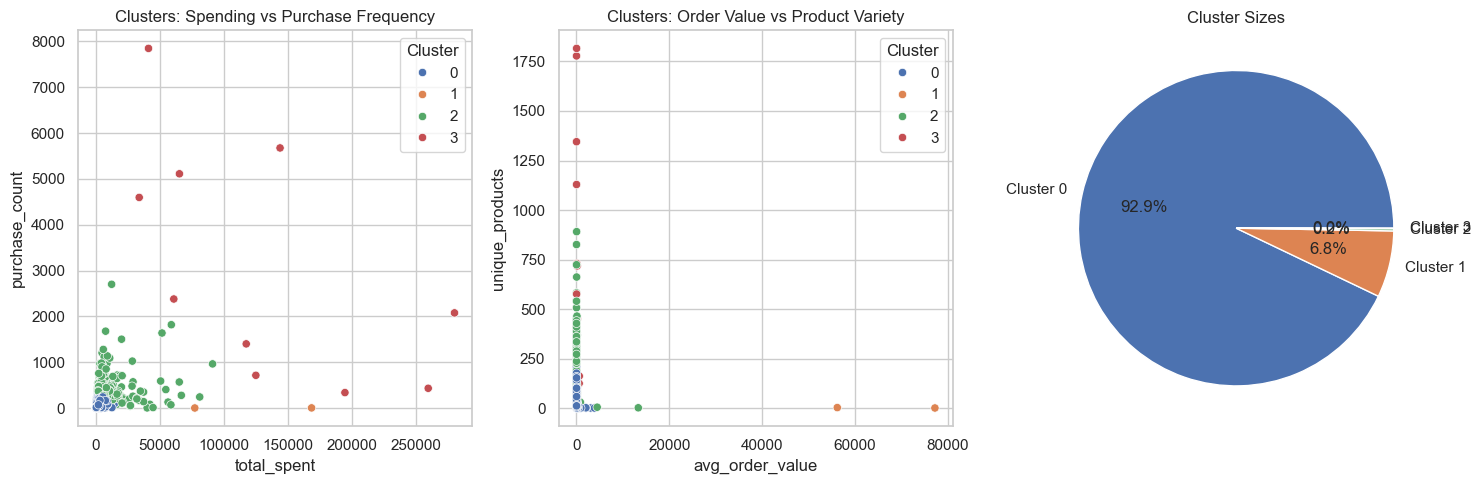

In [6]:
def segment_customers(features):
    """Perform customer segmentation using K-means clustering"""
    if features is None:
        return None
        
    try:
        # Select features for clustering
        cluster_features = features[['total_spent', 'purchase_count', 'avg_order_value']].copy()
        
        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(cluster_features)
        
        # Find optimal number of clusters
        inertias = []
        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(features_scaled)
            inertias.append(kmeans.inertia_)
        
        # Plot elbow curve
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, 11), inertias, marker='o')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()
        
        # Perform clustering with optimal k
        optimal_k = 4  # Based on elbow curve
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        cluster_labels = kmeans.fit_predict(features_scaled)
        
        # Add cluster labels to features
        features['Cluster'] = cluster_labels
        
        # Analyze clusters
        cluster_analysis = features.groupby('Cluster').agg({
            'total_spent': ['mean', 'count'],
            'purchase_count': 'mean',
            'avg_order_value': 'mean',
            'unique_products': 'mean'
        }).round(2)
        
        # Flatten column names
        cluster_analysis.columns = [
            'avg_total_spent',
            'customer_count',
            'avg_purchase_count',
            'avg_order_value',
            'avg_unique_products'
        ]
        
        print("Cluster Analysis:")
        display(cluster_analysis)
        
        # Visualize clusters
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        sns.scatterplot(data=features, x='total_spent', y='purchase_count', hue='Cluster', palette='deep')
        plt.title('Clusters: Spending vs Purchase Frequency')
        
        plt.subplot(132)
        sns.scatterplot(data=features, x='avg_order_value', y='unique_products', hue='Cluster', palette='deep')
        plt.title('Clusters: Order Value vs Product Variety')
        
        plt.subplot(133)
        cluster_sizes = features['Cluster'].value_counts()
        plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(len(cluster_sizes))], autopct='%1.1f%%')
        plt.title('Cluster Sizes')
        
        plt.tight_layout()
        plt.show()
        
        return features
        
    except Exception as e:
        print(f"Error in customer segmentation: {e}")
        return None

# Perform segmentation
segmented_customers = segment_customers(customer_features)

## 5. Conclusions and Recommendations

1. **Customer Value Prediction**:
   - Successfully built models to predict customer spending
   - Random Forest model shows strong performance
   - Key predictors identified through feature importance

2. **Customer Segmentation**:
   - Identified distinct customer segments
   - Each segment shows unique behavior patterns
   - Enables targeted marketing strategies

3. **Business Recommendations**:
   - Develop personalized marketing campaigns for each segment
   - Focus on high-value customer retention
   - Optimize inventory based on predictive insights